In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [2]:
X_train = pd.read_csv(r"C:/2023 Summer Data Analysis Prep/QRT challenge/X_train_NHkHMNU.csv")
y_train = pd.read_csv(r"C:/2023 Summer Data Analysis Prep/QRT challenge/y_train_ZAN5mwg.csv")
X_test = pd.read_csv(r"C:/2023 Summer Data Analysis Prep/QRT challenge/X_test_final.csv")
y_test = pd.read_csv(r"C:/2023 Summer Data Analysis Prep/QRT challenge/y_test_random_final.csv")

In [3]:
#initialise the submission
y_submission = X_test[["ID"]].copy()

In [4]:
y_submission.shape

(654, 1)

In [5]:
X_train.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [6]:
X_train.count()

ID                  1494
DAY_ID              1494
COUNTRY             1494
DE_CONSUMPTION      1494
FR_CONSUMPTION      1494
DE_FR_EXCHANGE      1469
FR_DE_EXCHANGE      1469
DE_NET_EXPORT       1370
FR_NET_EXPORT       1424
DE_NET_IMPORT       1370
FR_NET_IMPORT       1424
DE_GAS              1494
FR_GAS              1494
DE_COAL             1494
FR_COAL             1494
DE_HYDRO            1494
FR_HYDRO            1494
DE_NUCLEAR          1494
FR_NUCLEAR          1494
DE_SOLAR            1494
FR_SOLAR            1494
DE_WINDPOW          1494
FR_WINDPOW          1494
DE_LIGNITE          1494
DE_RESIDUAL_LOAD    1494
FR_RESIDUAL_LOAD    1494
DE_RAIN             1400
FR_RAIN             1400
DE_WIND             1400
FR_WIND             1400
DE_TEMP             1400
FR_TEMP             1400
GAS_RET             1494
COAL_RET            1494
CARBON_RET          1494
dtype: int64

In [7]:
X_train.shape

(1494, 35)

In [8]:
X_train.dtypes

ID                    int64
DAY_ID                int64
COUNTRY              object
DE_CONSUMPTION      float64
FR_CONSUMPTION      float64
DE_FR_EXCHANGE      float64
FR_DE_EXCHANGE      float64
DE_NET_EXPORT       float64
FR_NET_EXPORT       float64
DE_NET_IMPORT       float64
FR_NET_IMPORT       float64
DE_GAS              float64
FR_GAS              float64
DE_COAL             float64
FR_COAL             float64
DE_HYDRO            float64
FR_HYDRO            float64
DE_NUCLEAR          float64
FR_NUCLEAR          float64
DE_SOLAR            float64
FR_SOLAR            float64
DE_WINDPOW          float64
FR_WINDPOW          float64
DE_LIGNITE          float64
DE_RESIDUAL_LOAD    float64
FR_RESIDUAL_LOAD    float64
DE_RAIN             float64
FR_RAIN             float64
DE_WIND             float64
FR_WIND             float64
DE_TEMP             float64
FR_TEMP             float64
GAS_RET             float64
COAL_RET            float64
CARBON_RET          float64
dtype: object

In [9]:
X_train["COUNTRY"].unique()

array(['FR', 'DE'], dtype=object)

Only 2 unique values so use indicator variable

In [10]:
X_train["COUNTRY"] = X_train["COUNTRY"].map({'FR':0, 'DE':1})
# drop ID and DAY ID columns as there are not needed in the model
X_train.drop(['ID', 'DAY_ID'], axis=1, inplace=True)

In [11]:
X_test["COUNTRY"].unique()

array(['FR', 'DE'], dtype=object)

In [12]:
X_test["COUNTRY"] = X_test["COUNTRY"].map({'FR':0, 'DE':1})
# drop ID and DAY ID columns as there are not needed in the model
X_test.drop(['ID', 'DAY_ID'], axis=1, inplace=True)

In [13]:
# filling NA values with columns means
column_means_train = X_train.mean()
X_train = X_train.fillna(column_means_train)
column_means_test = X_test.mean()
X_test = X_test.fillna(column_means_test)

In [14]:
y_train, y_test = y_train["TARGET"], y_test["TARGET"]

In [15]:
columns = np.array(X_train.columns)

In [16]:
# columns that look relevant on first glance and LASSO confirms
relevant_cols = columns.take([0, 3,4,5,7,14,20,22,23,30])

In [17]:
relevant_cols

array(['COUNTRY', 'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT',
       'DE_NET_IMPORT', 'FR_HYDRO', 'FR_WINDPOW', 'DE_RESIDUAL_LOAD',
       'FR_RESIDUAL_LOAD', 'GAS_RET'], dtype=object)

In [18]:
lr = LinearRegression()
lr.fit(X_train[columns], y_train)
output_train = lr.predict(X_train[columns])
output_test = lr.predict(X_test[columns])

In [19]:
def metric_train(output, y):

    return spearmanr(output, y).correlation

print('Spearman correlation for the train set: {:.1f}%'.format(100 * metric_train(output_train, y_train) ))
print('Spearman correlation for the test set: {:.1f}%'.format(100 * metric_train(output_test, y_test) ))

Spearman correlation for the train set: 28.1%
Spearman correlation for the test set: -1.0%


In [20]:
lr_cv = LinearRegression()
scores = cross_val_score(lr_cv, X_train, y_train, scoring='r2', cv=5)

In [21]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(X_train)
test_mat = poly.transform(X_test)

In [22]:
lr_poly = LinearRegression()
lr_poly.fit(poly_features, y_train)

LinearRegression()

In [23]:
y_submission["TARGET"] = lr_poly.predict(test_mat)

In [25]:
lr_poly.predict(test_mat)

array([-4.52382471e+06,  3.49961781e+06,  1.13545793e+08, -6.14021339e+06,
        3.83026472e+07,  1.45859745e+08,  5.67282469e+05,  6.66397022e+07,
       -4.40494499e+07,  1.43540443e+07,  2.82221741e+07,  8.76933903e+07,
        5.41543539e+07, -8.76863896e+07,  7.50554577e+07, -1.09932667e+07,
        1.45128874e+08, -2.90512966e+07,  3.42455134e+07,  4.79242278e+07,
        3.12248735e+07, -1.68686324e+08,  6.55920360e+07, -6.41982280e+07,
        1.79930788e+08, -4.28001507e+07,  3.66876014e+07, -3.45309163e+08,
        3.19434990e+07,  1.62629925e+08, -2.00708062e+08, -4.05466550e+06,
       -1.17710085e+08, -3.62102125e+07, -4.43028212e+06,  7.66178631e+07,
       -5.37980095e+07, -7.19068820e+07, -1.29434750e+08,  7.76531647e+07,
       -3.61979027e+07,  2.25108095e+07,  1.41139293e+08,  1.75707176e+06,
       -3.56371401e+08,  6.68886950e+07, -1.81612984e+08, -2.97916195e+07,
       -1.07348298e+08,  3.76029779e+07,  2.96138980e+09, -2.60126891e+07,
       -5.74571293e+06, -

In [24]:
y_submission

,ID,TARGET
0,1115,-4.523825e+06
1,1202,3.499618e+06
2,1194,1.135458e+08
3,1084,-6.140213e+06
4,1135,3.830265e+07
...,...,...
649,879,-3.772069e+07
650,673,-2.389486e+08
651,1641,-1.206099e+07
652,712,2.604793e+07


In [48]:
y_submission.to_csv(r"C:\Users\rijul\Downloads\submission file\y_test_submission_5.csv", index=False)

In [245]:
y_test[:]

0     -0.052395
1     -0.112118
2      1.050431
3     -1.267154
4      0.751565
         ...   
649   -0.628430
650    0.443745
651    0.338772
652   -0.761823
653   -2.313221
Name: TARGET, Length: 654, dtype: float64

In [160]:
# Normalize input features
X_train_normalized = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_test_normalized = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)

# Split data into training and validation sets
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train_normalized.to_numpy(), y_train.to_numpy(), test_size=0.1, random_state=42)


In [170]:
model_nn = keras.Sequential([
    keras.layers.Dense(units=128, activation='relu', input_shape=(33,)),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1)
])

In [171]:
model_nn.compile(optimizer='sgd', 
              loss='mse')

history = model_nn.fit(
    X_train_nn, 
    y_train_nn,
    epochs=90,
    batch_size=32,
    validation_data=(X_val_nn, y_val_nn)
)

Epoch 1/90
42/42 [==============================] - 1s 8ms/step - loss: 1.1592 - val_loss: 0.9969
Epoch 2/90
42/42 [==============================] - 0s 3ms/step - loss: 1.0584 - val_loss: 0.9775
Epoch 3/90
42/42 [==============================] - 0s 3ms/step - loss: 1.0232 - val_loss: 0.9725
Epoch 4/90
42/42 [==============================] - 0s 3ms/step - loss: 0.9998 - val_loss: 0.9656
Epoch 5/90
42/42 [==============================] - 0s 3ms/step - loss: 0.9812 - val_loss: 0.9628
Epoch 6/90
42/42 [==============================] - 0s 3ms/step - loss: 0.9608 - val_loss: 0.9731
Epoch 7/90
42/42 [==============================] - 0s 3ms/step - loss: 0.9480 - val_loss: 0.9690
Epoch 8/90
42/42 [==============================] - 0s 3ms/step - loss: 0.9361 - val_loss: 0.9686
Epoch 9/90
42/42 [==============================] - 0s 3ms/step - loss: 0.9201 - val_loss: 0.9749
Epoch 10/90
42/42 [==============================] - 0s 3ms/step - loss: 0.9050 - val_loss: 0.9998
Epoch 11/90
42/42 [

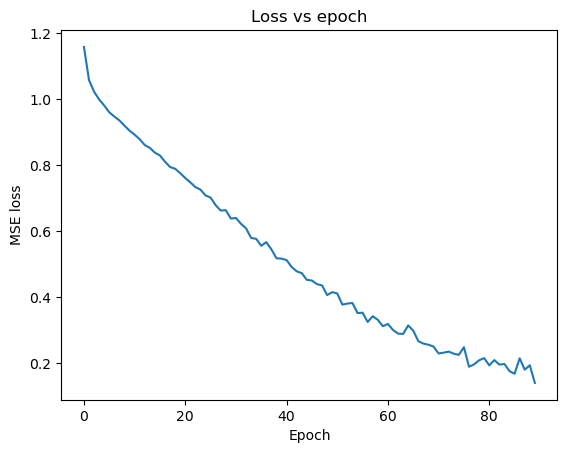

In [172]:
plt.plot(history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Loss vs epoch")
plt.show()

In [173]:
y_pred = model_nn.predict(X_test_normalized.to_numpy())

21/21 [==============================] - 0s 1ms/step


In [140]:
# add and save the predictions
# only run cell once
y_submission['TARGET'] = y_pred
y_submission.to_csv(r"C:\Users\rijul\Downloads\submission file\y_test_submission_4.csv", index=False)

In [174]:
y_pred

array([[ 1.70051530e-01],
       [ 5.65312624e-01],
       [-5.00075221e-02],
       [ 6.20642543e-01],
       [ 4.16905493e-01],
       [ 5.07782221e-01],
       [-1.80685967e-01],
       [ 1.69898748e-01],
       [-3.70785296e-02],
       [-2.55915433e-01],
       [-5.84803224e-02],
       [-2.70404577e-01],
       [ 2.31783748e-01],
       [-4.75405157e-02],
       [ 7.53012538e-01],
       [ 6.22450590e-01],
       [-3.45639974e-01],
       [ 4.48337555e-01],
       [-2.69933909e-01],
       [-5.76379299e-01],
       [ 5.12503624e-01],
       [ 4.23934817e-01],
       [ 9.67627287e-01],
       [-4.81845886e-02],
       [-1.68253362e-01],
       [-3.48115742e-01],
       [ 1.17425847e+00],
       [ 1.34315419e+00],
       [-9.74451005e-02],
       [-1.48571646e+00],
       [ 4.41895753e-01],
       [-5.00080347e-01],
       [ 7.53358245e-01],
       [ 1.33772105e-01],
       [ 3.54248077e-01],
       [ 3.05771828e-02],
       [-4.55469757e-01],
       [-9.22873735e-01],
       [ 1.6

In [169]:
y_test

0     -0.052395
1     -0.112118
2      1.050431
3     -1.267154
4      0.751565
         ...   
649   -0.628430
650    0.443745
651    0.338772
652   -0.761823
653   -2.313221
Name: TARGET, Length: 654, dtype: float64